# Continuous Bag of Words - Word Embeddings

We can represent the words as numerical vectors for computers to interpret human words. Word embeddings are one of the ways.

The CBOW technique captures the context of the word to better understand the relationship between words (syntactic and semantic structures).

Word vectors can be a building block of many Natural Language Processing tasks.


## Outline

- [The Idea of CBOW](#1)
- [Data preprocessing](#2)
- [Prepare training data](#3)
- [Building and training the model](#4)
- [Visualizing the word vectors](#5)
- [Discussion](#6)


<a name='1'></a>
## 1. The idea of CBOW

- In CBOW modeling, we try to predict the center word given a few context words (the words around the center word).

- For example, if you were to choose a context half-size of say $C = 2$, then you would try to predict the word **happy** given the context that includes 2 words before and 2 words after the center word:

>**'I am happy because I am learning'**.

> $context = [I,am, because, I]$

> $target = happy$

The structure of your model will look like this:

<img src='https://drive.google.com/uc?id=11UcTETIGoFccIxp1PS75OSXPPNxWn_sa' width='600'>


Where $\bar x$ is the average of all the one hot vectors of the context words.

<img src='https://drive.google.com/uc?export=view&id=1bNSRUb1j3i4BkZB4gQMnYcJZS0PYZ0Xx' width='600'>

Once you have encoded all the context words, you can use $\bar x$ as the input to your model.


<a name='2'></a>
## Data Preprocessing

Load the text to train with. I will use one of Shakespeare's texts.

In [1]:
from google.colab import files
upload = files.upload()

# A list of sentences separated by newline characters
with open('shakespeare.txt') as f:
    corpus = [line.rstrip('\n') for line in f]

Saving shakespeare.txt to shakespeare.txt


Preprocess the text.

1. Tokenization
2. Remove punctuation
   - punctuation is unimportant in training.
3. Converting text to lowercase
4. Handle special characters (ex. emoji)


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize and create vocabulary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [3]:
word_index_example = dict(list(word_index.items())[0: 5])
print(word_index_example)

{'the': 1, 'and': 2, 'to': 3, 'i': 4, 'of': 5}


<a name='3'></a>
## Prepare training data

Now, generate the training data. X_train is the arrays of tokenized context words in the sentence, and y_train is the target words.

Two things are happening here:
1. building the context window
2. creating context-target (input-output) pairs

In [4]:
import numpy as np

context_window = 2

def generate_data(corpus, context_window, tokenizer):
    sequences = tokenizer.texts_to_sequences(corpus)
    X, y = [], []
    for sequence in sequences:
        for i in range(context_window, len(sequence) - context_window):
            context = sequence[i - context_window : i] + sequence[i + 1 : i + context_window + 1]
            target = sequence[i]
            X.append(context)
            y.append(target)
    return np.array(X), np.array(y)

X_train, y_train = generate_data(corpus, context_window, tokenizer)

<a name='4'></a>
## Training the Model

### Initializing the model
1. Embedding layer enables us to convert each word into a fixed length vector of defined size. The fixed length of word vectors helps us to represent words in a better way along with reduced dimensions. It's more efficient than one-hot encoding since this will take up much less space.

2. GlobalAveragePooling1D layer averages out the embedding to get the context of the context words.

3. Finally, a Dense layer with softmax activation function is used to output the result.

In [15]:
# A higher dimension gives a more complex relationship between words,
# but it costs more resources and comes at a diminishing result after 300
embedding_dim = 100

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                              input_length=context_window*2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

Use checkpoints to save in between epochs.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

fname = 'weights-{epoch:03d}-{loss:.4f}.hdf5'

checkpoint = ModelCheckpoint(fname, monitor="loss", mode="min",
	save_best_only=True, verbose=0)

history = model.fit(X_train, y_train,	batch_size=16, epochs=200,
              callbacks=checkpoint, verbose=1)


Display some result. This result is achieved after 500+ epoches.

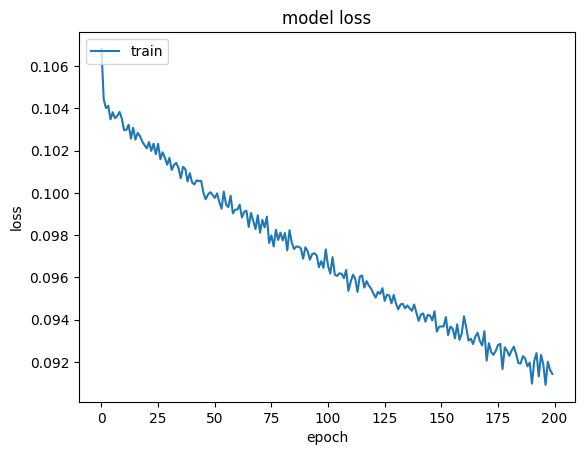

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

<a name='5'></a>
## Visualizing the word vectors

I will choose some words to check their relationships with each other.

In [130]:

dictlist = []

words_to_check = ['lord', 'he', 'she', 'they', 'you', 'sir', 'i',
                  'man', 'king', 'queen', 'wolf']

for key, value in tokenizer.word_index.items():
    temp = (key,value)
    if key in words_to_check:
      dictlist.append(temp)

dictlist

[('i', 4),
 ('you', 10),
 ('he', 25),
 ('lord', 36),
 ('king', 52),
 ('she', 53),
 ('they', 54),
 ('sir', 71),
 ('man', 123),
 ('queen', 333),
 ('wolf', 4062)]

Use Principal Component Analysis (PCA) method to reduce the embedding dimensions to 2-D for the ease of interpretation.

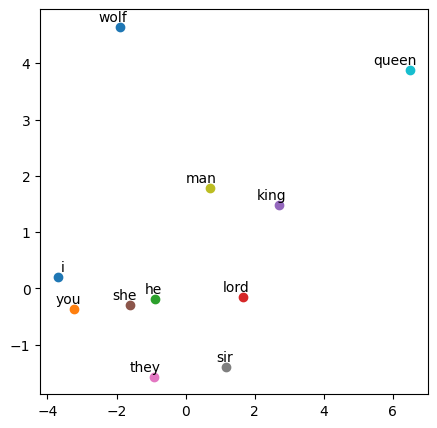

In [131]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Get the word embeddings
embeddings = model.get_weights()[0]

# Perform PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualize the embeddings
plt.figure(figsize=(5, 5))

for word, index in dictlist:
    x, y = reduced_embeddings[index]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points',
                 ha='right', va='bottom')
plt.show()

We can extract some information from the result above.

1. 'man' and 'king' are close.
2. Pronouns (ex. i, he, she...) are clustered at the left-bottom corner.
3. 'wolf' is by itself at the left-top corner
4. 'queen' is by itself at the right-top corner

We have to be careful that this result is simplified by PCA.

<a name='6'></a>
## Discussion

There are a few challenges associated with CBOW, as explained here (https://spotintelligence.com/2023/07/27/continuous-bag-of-words/#How_can_you_overcoming_challenges_and_limitations_associated_with_the_CBOW_model):

1. Handling Out-of-Vocabulary (OOV) Words
   - Subword embedding, where the unknown word is split into pieces for inference, can be used.
2. Polysemy and Homonymy
   - CBOW treats each word as a single entity with a single meaning. More context-sensitive word embedding models like BERT are developed.
3. Data Sparsity
   - Obtaining high-quality word embeddings with CBOW can be challenging with limited resources. To mitigate data sparsity, researchers may resort to transfer learning, fine-tuning pre-trained embeddings from larger corpora on their specific dataset or domain.
4. Context Window Size Selection
   - A small window may not provide sufficient context information, while a large window may introduce noise and dilute the relevant information. The optimal context window size often depends on the specific NLP task and the dataset’s characteristics. Experimentation and hyperparameter tuning are essential.
5. Scalability
    - CBOW can be computationally intensive, especially for large vocabularies and datasets. Training a CBOW model on massive text corpora may require significant computational resources and time. To overcome this challenge, researchers may consider using word2vec libraries like Gensim, which efficiently implement CBOW and other word embedding techniques that can leverage multi-core processors and distributed computing.